# Gas Boiler to heat pump dynamic Material Flow analysis
This doc uses the dynamic_stock_model package

The objective is to replace every boiler by heat pumps by 2050 in Vaud Canton

## Import data

In [1]:
import dynamic_stock_model as dsm 
import numpy as np
import matplotlib.pyplot as plt
import openpyxl


In [7]:
# Vaud number housing
housing_2024= 381144

# increase of the number of housing

housing_increase_2024 = 0.005

# Proportion of HP
prop_HP_2024 = 0.17
# Proportion of GB
prop_GB_2024 = 0.30

# Lifetime HP
lifetime_HP_2024 = [20]*(46)  # from 2015 to 2050

# Lifetime GB
lifetime_GB_2024 = [20]*(46)  # from 2015 to 2050

# std lifetime 
std_GB=0.25
std_HP=0.25

# density functions
HP_pdf='Normal'
GB_pdf='Normal'

# Define time range
Years = np.arange(2015, 2051) # 2015 to 2025 is the initialisation then 2025 to 2050 is the projection



## Initial parameters


In [79]:
# Use previous import of GB sales in Vaud
GB_sales =[housing_2024*prop_GB_2024/21]*21+[0]*26
print(GB_sales, len(GB_sales))

# Calculate housing increase over time for future years
Housing_past=[333955,339882, 344627, 349758, 354496, 360928, 366389, 370394, 376518, housing_2024]#2015 to 2024
Housing_increase=[housing_2024*(1+housing_increase_2024)**i -housing_2024 for i in range(0,26)]
Housing_f=[housing_2024*(1+housing_increase_2024)**i for i in range(0,26)]
Housing=Housing_past+Housing_f
print(Housing, len(Housing))

[5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 47
[333955, 339882, 344627, 349758, 354496, 360928, 366389, 370394, 376518, 381144, 381144.0, 383049.72, 384964.9685999999, 386889.7934429999, 388824.24241021485, 390768.3636222658, 392722.2054403772, 394685.81646757905, 396659.2455499169, 398642.54177766637, 400635.7544865547, 402638.93325898744, 404652.12792528234, 406675.3885649087, 408708.76550773316, 410752.3093352718, 412806.07088194817, 414870.1012363578, 416944.45174253953, 419029.17400125216, 421124.3198712584, 423229.9414706147, 425346.09117796767, 427472.8

## Create the models

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031
 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045
 2046 2047 2048 2049 2050]
output flow [0.00000000e+00 3.17925197e-01 9.84275910e-01 2.32614146e+00
 4.92237264e+00 9.74857959e+00 1.83683707e+01 3.31599913e+01
 5.75472509e+01 9.61784744e+01 1.54973711e+02 2.40949080e+02
 3.61739968e+02 5.24790611e+02 7.36255896e+02 9.99757867e+02
 1.31522700e+03 1.67810288e+03 2.07914275e+03 2.50498154e+03
 2.93942285e+03 3.36526164e+03 3.76598358e+03 4.12819311e+03
 4.44232038e+03 4.70322612e+03 4.90986520e+03 5.06429605e+03
 5.17029532e+03 5.23188343e+03 5.25204744e+03 5.23188343e+03
 5.17029532e+03 5.06429605e+03 4.90986520e+03 4.70322612e+03
 4.44232038e+03 4.12819311e+03 3.76598358e+03 3.36526164e+03
 2.93956858e+03 2.50519147e+03 2.07937984e+03 1.67835101e+03
 1.31547945e+03 1.00001193e+03 7.36510545e+02]
('<br><b> Checking dimensions 

Text(0, 0.5, 'Number of Gas Boilers')

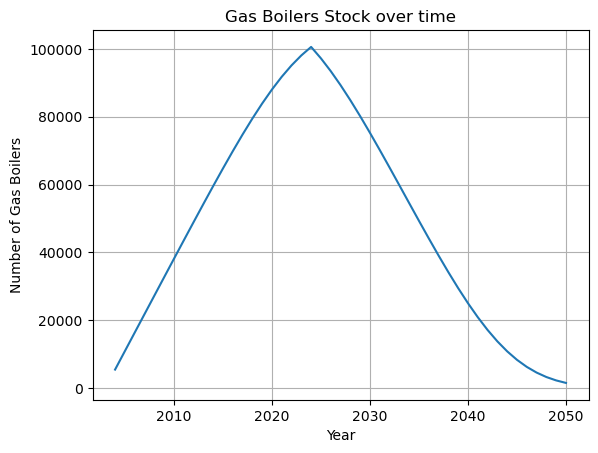

In [ ]:
# inflow driven model for Gas boilers
# over 2004-2024 and then projection 2025-2050
Years_GB=np.arange(2004,2051)
GB_DSM = dsm.DynamicStockModel(t = Years_GB, 
                               i =GB_sales, lt = {'Type': GB_pdf, 'Mean': lifetime_GB_2024, 'StdDev': std_GB* np.array(lifetime_GB_2024)},)



# compute stock
S_C, O_C= GB_DSM.compute_s_c_inflow_driven()
O_C= GB_DSM.compute_o_c_from_s_c()

S=GB_DSM.compute_stock_total()
O=GB_DSM.compute_outflow_total()
check_GB=GB_DSM.dimension_check()
print("output flow", GB_DSM.o)

# plot stock
print(check_GB)
plt.grid()
plt.plot( GB_DSM.t,GB_DSM.s, label='Gas Boilers Stock')
plt.title('Gas Boilers Stock over time')
plt.xlabel('Year')
plt.ylabel('Number of Gas Boilers')


In [ ]:
# Model for the heat pumps STOCK driven model
# past stock
HP_percent=[4.4/100, 5.1/100, 5.9/100, 6.8/100, 7.9/100, 9.2/100, 10.7/100, 12.4/100, 14.7/100, 16.7/100] # from 2015 to 2024
HP_stock_i =[x*h for x,h in zip(HP_percent,Housing_past)]  # from 2015 to 2024

# from 2025 to 2050
H=[HP_stock_i[-1]]*(2050-2024)
print(H)
HP_stock_f = [a+b+(prop_GB_2024+prop_HP_2024)*hi for a,b,hi in zip(H,GB_DSM.o.tolist()[-(2050-2024):],Housing_increase[-(2050-2024):])]  # from 2015 to 2024 is the initialisation then 2025 to 2050 is the projection

# total stock
HP_stock= HP_stock_i + HP_stock_f
print(HP_stock)

# add new DSM for heat pumps

HP_DSM = dsm.DynamicStockModel(t = Years, 
                               s =HP_stock, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

[63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995, 63651.047999999995]
[14694.020000000002, 17333.982, 20332.993000000002, 23783.544, 28005.184, 33205.376, 39203.623, 45928.856, 55348.14599999999, 63651.047999999995, 67016.30963617309, 68312.7199805636, 69575.09635197883, 70793.89129745447, 71963.98805179597, 73084.36409948679, 74157.10060623949, 75185.9970558457, 76175.09683391801, 77127.41007446004, 78044.05603413779, 78923.96194780763, 79764.16417414491, 80560.66582252894, 81309.71390762957, 82009.27376682228, 82660.4144244945, 83268.2991616

63651.047999999995
('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 36 years.<br>Inflow vector is present with 36 years.<br>Total stock is present with 36 years.<br>Stock by cohorts is present with 36 years and 36 cohorts.<br>Total outflow is not present.<br>Outflow by cohorts is present with 36 years and 36 cohorts.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


Text(0, 0.5, '% of Heat pumps')

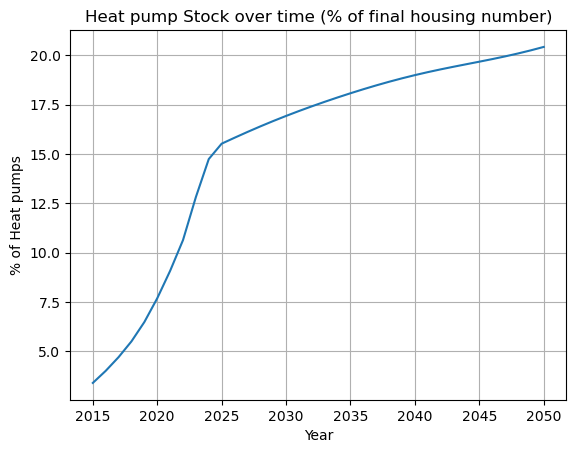

In [84]:
# compute stock driven model to get inflow
I_C1= HP_DSM.compute_stock_driven_model()

S1=HP_DSM.compute_stock_total()
check_HP=HP_DSM.dimension_check()
print(HP_DSM.s[9])
# plot stock
print(check_HP)
plt.grid()
plt.plot( HP_DSM.t,np.array(HP_DSM.s)/(housing_2024+Housing_increase[-1])*100, label='Heat pump Stock')
plt.title('Heat pump Stock over time (% of final housing number)')
plt.xlabel('Year')
plt.ylabel('% of Heat pumps')

## Calculating an incentive to buy HP 
Target of 55% in 2050(from https://www.sciencedirect.com/science/article/pii/S0301421525002253)

In [80]:
incentive_HP=1.5/100

# calculate converted households
Converted_households=[incentive_HP*(housing_2024-HP_stock_i[-1])]

for i in range(1,26):
    Converted_households.append(incentive_HP*(Housing[26-i]-HP_stock[26-i]-Converted_households[-1])+Converted_households[-1])
print(Converted_households)
HP_stock_f1 = [a+ b for a,b in zip(HP_DSM.s[-(2050-2024):],Converted_households)]
print(len(HP_stock_f1))


[4762.3942799999995, 9622.103899326743, 14388.758114838396, 19064.647584251517, 23651.997326754805, 28152.94193652118, 32569.523284259616, 36903.707410543815, 41157.41403012564, 45332.550110849756, 49431.038431699075, 53454.83284806527, 57405.91417072057, 61286.263990342944, 65097.818114208116, 68842.40584278654, 72521.68511060215, 76196.25411394311, 79870.85811223397, 83539.77240055046, 87194.4564695422, 90802.37898249907, 94337.70553776158, 97812.25679469515, 101209.48304777472, 104529.5610720581]
26


In [81]:

# total stock
HP_stock1= HP_stock_i + HP_stock_f1
print(HP_stock)

# add new buildings

HP_DSM_incentive = dsm.DynamicStockModel(t = Years, 
                               s =HP_stock1, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

[14694.020000000002, 17333.982, 20332.993000000002, 23783.544, 28005.184, 33205.376, 39203.623, 45928.856, 55348.14599999999, 63651.047999999995, 67016.30963617309, 68312.7199805636, 69575.09635197883, 70793.89129745447, 71963.98805179597, 73084.36409948679, 74157.10060623949, 75185.9970558457, 76175.09683391801, 77127.41007446004, 78044.05603413779, 78923.96194780763, 79764.16417414491, 80560.66582252894, 81309.71390762957, 82009.27376682228, 82660.4144244945, 83268.2991616518, 83842.52195516667, 84396.648365433, 84946.98980797961, 85510.82033145051, 86104.38186753255, 86741.07361546016, 87430.1672304954, 88176.24977986491]


('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 36 years.<br>Inflow vector is present with 36 years.<br>Total stock is present with 36 years.<br>Stock by cohorts is present with 36 years and 36 cohorts.<br>Total outflow is not present.<br>Outflow by cohorts is present with 36 years and 36 cohorts.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


Text(0, 0.5, '% Heat pumps')

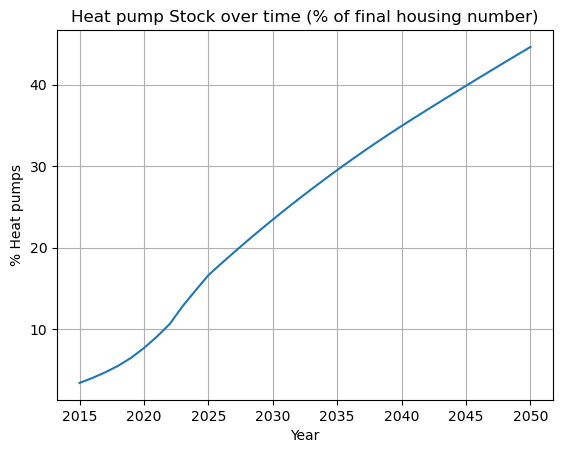

In [82]:
# compute stock driven model to get inflow
HP_inc= HP_DSM_incentive.compute_stock_driven_model()

S_inc=HP_DSM_incentive.compute_stock_total()
check_HP_inc=HP_DSM_incentive.dimension_check()
# plot stock
print(check_HP_inc)
plt.grid()
plt.plot( HP_DSM_incentive.t,np.array(HP_DSM_incentive.s)/(housing_2024+Housing_increase[-1])*100, label='Heat pump Stock')
plt.title('Heat pump Stock over time (% of final housing number)')
plt.xlabel('Year')
plt.ylabel('% Heat pumps')

# Flow modelling:
electricity import,
gas import,
CO2 emissions,
Copper use, copper waste

In [ ]:
# Data

# Household energy consumption
S_household=95 #m2 de surface habitable average
cons_surface=30 #kWh/m² par an

# Heat pump
COP=3.26 # Coefficient of performance

# Gas boiler
LHV_gas= 50 # MJ/kg


# emissions
e_elec= 0.0273 #kgCO2/kWh
e_gas_boiler= 0.0754 #kgCO2/MJ  !!

# Copper
copper_HP= 25 #kg
copper_GB= 1.5 #kg

## Sensitivity analysis